# Boundary Value Solver

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
from scipy.spatial.distance import euclidean

plt.rcParams['figure.figsize'] = (10,5)

\begin{matrix} v'=v^2-\frac{11}{10}v+\frac 53e \\ e'=-\frac 12v^3+\frac{11}{10}v^2-\frac{33}{50}v+ve\text. \end{matrix}

<img src="viz_mono.png" alt="Drawing" style="width: 700px;"/>

## Problem 1
Determine the fixed points of the ODE system and classify their type.
To classify their type, state that the fixed point is a center, saddle, sink, etc.

$(v,e)$  
$(0,0)$ - spiral sink  
$(0.6, 0.18)$ - saddle  
$(1, 0.06)$ - source  

## Problem 2
Draw a phase portrait for the ODE system. Include fixed points, connecting orbits, and a few representative orbits.

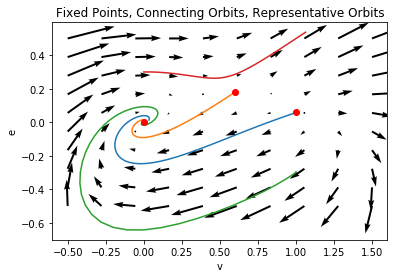

In [13]:
dv = lambda v, e: v**2 - 1.1*v + 5/3*e
de = lambda v, e: -0.5*v**3 + 1.1*v**2 - 0.66*v + v*e

α = 0.1

def solve_forward(v0, e0, n_forward=100):
    vs, es = [v0], [e0]
    v, e = v0, e0
    for i in range(n_forward):
        delta_v = dv(v, e)
        delta_e = de(v, e)
        v += α*delta_v
        e += α*delta_e
        vs.append(v)
        es.append(e)
    return vs, es
        

n_density = 10

fixed_points = np.array([
    [0, 0],
    [0.6, 0.18],
    [1, 0.06]
])

V = np.linspace(-0.5, 1.5, n_density)
E = np.linspace(-0.5, 0.5, n_density)
X, Y = np.meshgrid(V, E)

vs_1, es_1 = solve_forward(1, 0.059)
vs_2, es_2 = solve_forward(0.6, 0.179)
vs_3, es_3 = solve_forward(1, -0.3)
vs_4, es_4 = solve_forward(0, 0.3, n_forward=40)

plt.quiver(X, Y, dv(X,Y), de(X,Y))
plt.plot(vs_1, es_1)
plt.plot(vs_2, es_2)
plt.plot(vs_3, es_3)
plt.plot(vs_4, es_4)
plt.scatter(fixed_points[:,0], fixed_points[:,1], color='red', zorder=3)
plt.xlabel("v")
plt.ylabel("e")
plt.title("Fixed Points, Connecting Orbits, Representative Orbits")
plt.show()

## Problem 3 & 4
Develop from scratch an ODE boundary solver.
Use your ODE boundary solver to solve for any connecting orbits present in the phase diagram.

(2, 10)
[[ 1.00425095e+00  1.00696431e+00  1.01054640e+00  1.01224718e+00
   9.97290380e-01  9.04985049e-01  5.75809543e-01  1.98208300e-02
  -1.87868885e-01 -9.59787714e-02]
 [ 5.90000000e-02  5.81611434e-02  5.63679906e-02  5.19537188e-02
   3.94539679e-02  1.73474583e-04 -1.19805699e-01 -2.67637459e-01
  -1.35717767e-01 -1.57209315e-18]]


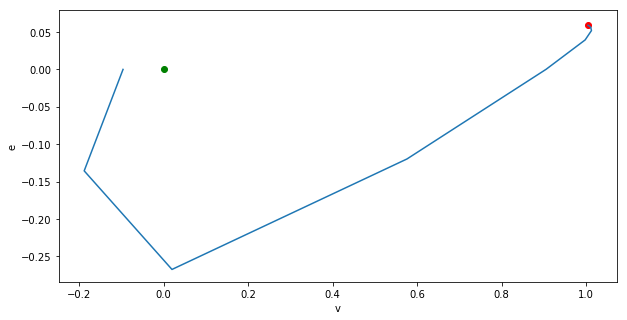

In [89]:
def my_bvp(x_prime, interval, f, tol=0.001):
    pass

# Define ODE
def fun(t, y):
    v, e = y
    delta_v = dv(v, e)
    delta_e = de(v, e)
    ret_val = np.array([delta_v, delta_e])
    return ret_val

v0, e0 = 1, 0.059
vn, en = 0, 0
# Define boundary condition residual
def bcs(ya, yb):
    y0 = np.array([1, 0.059])
    yn = np.array([0, 0])
    return np.array([ya[1]-e0, yb[1]-en])

# Init time and boundary conditions
t = np.linspace(0, 9, 10)
bc = np.array([v0, e0])
y = bc.reshape((-1,1)) * np.ones((2,len(t)))

# Solve the ODE
solution = integrate.solve_bvp(fun=fun, bc=bcs, x=t, y=y)
print(solution.sol(t).shape)
print(solution.sol(t))

# Plot it all
plt.plot(solution.sol(t)[0], solution.sol(t)[1])
plt.scatter(solution.sol(t)[0][0], solution.sol(t)[1][0], color='red')
plt.scatter([0], [0], color='green')
plt.xlabel("v")
plt.ylabel("e")
plt.show()